In [1]:
import pandas as pd
import datetime as dt

# 1. Load datasets
complete = pd.read_csv("Complete3.csv")
customer = pd.read_csv("customer.csv")

# 2. Remove duplicate TransactionDate from customer dataset
if 'TransactionDate' in customer.columns:
    customer.drop(columns=['TransactionDate'], inplace=True)

# 3. Merge datasets
df = pd.merge(complete, customer, on='CustomerID', how='left')

# 4. Ensure TransactionDate is datetime
# Check the columns after merge to confirm the correct transaction date column name
print(df.columns)
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce', format='%d/%m/%y')

# 5. Remove rows without valid dates or amounts
df.dropna(subset=['TransactionDate', 'Quantity'], inplace=True)

# 6. Snapshot date = 1 day after the latest transaction
snapshot_date = df['TransactionDate'].max() + dt.timedelta(days=1)

# 7. Calculate RFM
rfm = df.groupby('CustomerID').agg(
    Recency=('TransactionDate', lambda x: (snapshot_date - x.max()).days),
    Frequency=('TransactionDate', 'nunique'),
    Monetary=('Quantity', 'sum')
).reset_index()

# 8. Rename columns (This step is now redundant as columns are named in step 7, but leaving for clarity)
# rfm.rename(columns={'TransactionDate': 'Frequency'}, inplace=True)
# rfm.rename(columns={'Quantity': 'Monetary'}, inplace=True)


# 9. Define churn (no purchase in last 180 days)
rfm['Churned'] = (rfm['Recency'] > 180).astype(int)

# 10. Save cleaned RFM dataset
rfm.to_csv("RFM_Cleaned.csv", index=False)

print("RFM data prepared and saved as RFM_Cleaned.csv")
display(rfm.head())

Index(['TransactionID', 'CustomerID', 'Name', 'Gender', 'Age', 'Region',
       'ProductID', 'ProductName', 'Category', 'Quantity', 'Sales',
       'TransactionDate', 'Recency', 'Frequency', 'Monetary'],
      dtype='object')
RFM data prepared and saved as RFM_Cleaned.csv


,CustomerID,Recency,Frequency,Monetary,Churned
0,CUST0000,12,6,20,0
1,CUST0002,9,3,4,0
2,CUST0003,65,6,20,0
3,CUST0004,64,5,17,0
4,CUST0005,167,3,8,0


📊 Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00         8

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



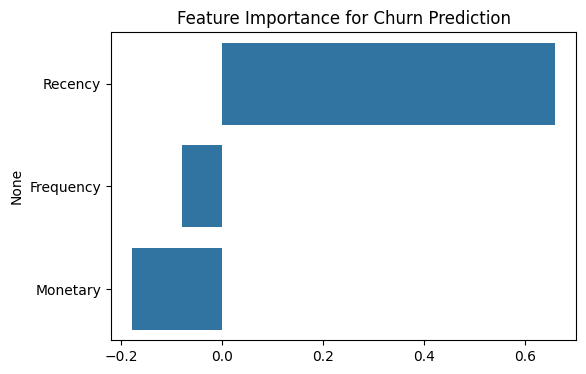

📉 Churn Rate: 7.74% of customers are inactive (>180 days).
Full RFM data with churn probability saved as RFM_with_Churn.csv

🚨 Top 10 At-Risk Customers:
    CustomerID  Recency  Frequency  Monetary  Churn_Probability
148   CUST0150      246          2         4           1.000000
222   CUST0225      305          1         4           1.000000
22    CUST0023      263          6        14           1.000000
192   CUST0194      299          2         7           1.000000
46    CUST0048      222          3         9           1.000000
195   CUST0197      209          3         9           1.000000
79    CUST0081      201          5        17           0.999957
9     CUST0010      194          2         5           0.999601
226   CUST0229      179          2         7           0.081077
108   CUST0110      165          3        11           0.000004
  CustomerID  Recency  Frequency  Monetary  Churned
0   CUST0000       12          6        20        0
1   CUST0002        9          3       

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Features & target
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Churned']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 3. Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# 4. Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of churn

# 5. Evaluation
print("📊 Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 6. Feature importance plot
importance = pd.Series(model.coef_[0], index=X.columns)
plt.figure(figsize=(6,4))
sns.barplot(x=importance.values, y=importance.index)
plt.title("Feature Importance for Churn Prediction")
plt.show()

# 7. Churn rate
churn_rate = rfm['Churned'].mean() * 100
print(f"📉 Churn Rate: {churn_rate:.2f}% of customers are inactive (>180 days).")

# Add churn probability for all customers
rfm['Churn_Probability'] = model.predict_proba(X)[:, 1]

# Save full churn dataset
rfm.to_csv("RFM_with_Churn.csv", index=False)
print("Full RFM data with churn probability saved as RFM_with_Churn.csv")

# 8. Top at-risk customers
rfm_test = rfm.loc[X_test.index].copy()
rfm_test['Churn_Probability'] = y_pred_proba
top_at_risk = rfm_test.sort_values('Churn_Probability', ascending=False).head(10)

print("\n🚨 Top 10 At-Risk Customers:")
print(top_at_risk[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Churn_Probability']])

# Save results for reporting
top_at_risk.to_csv("Top_At_Risk_Customers.csv", index=False)

import pandas as pd

# Load your RFM dataset (should include CustomerID, Recency, Frequency, Monetary, and Churned flag)
rfm = pd.read_csv("RFM_Cleaned.csv")

# Quick check
print(rfm.head())
print(rfm['Churned'].value_counts())

from sklearn.linear_model import LogisticRegression

# Features and target
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Churned']

# Model
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# Predict probabilities
rfm['Churn_Probability'] = model.predict_proba(X)[:, 1]

clusters = pd.read_csv("Customer_Churn_and_Clusters.csv")  # Should have CustomerID, Cluster

# Merge
merged = pd.merge(rfm, clusters, on='CustomerID', how='left')

# Check all clusters have churn probabilities
print(merged.groupby('Cluster')['Churn_Probability_y'].count())

merged.to_csv("Customer_Churn_and_Clusters.csv", index=False)


In [8]:
import pandas as pd

# 1️⃣ Load your dataset (from churn model output)
df = pd.read_csv("Customer_Churn_and_Clusters.csv")

# 2️⃣ Rename Python training vars to meaningful names
# If your file literally has columns "x" or "y", rename them
df.rename(columns={
    'y': 'Churned',
    # If your X was a dataframe, it should already be split into Recency/Frequency/Monetary
    # But if not, adjust below to your actual column names
}, inplace=True)

# 3️⃣ Ensure correct column order (optional, for clarity)
expected_columns = [
    'CustomerID',       # unique customer identifier
    'Recency',          # from RFM
    'Frequency',        # from RFM
    'Monetary',         # from RFM
    'Churned',          # 0 = active, 1 = churned
    'Churn_Probability',# from logistic regression
    'Cluster',          # from R clustering
    # any extra columns like Region, ProductCategory, etc.
]

# Keep only columns that exist in your file
df = df[[col for col in expected_columns if col in df.columns]]

# 4️⃣ Check data types for Tableau compatibility
df['CustomerID'] = df['CustomerID'].astype(str)
if 'Cluster' in df.columns:
    df['Cluster'] = df['Cluster'].astype(str)
if 'Churned' in df.columns:
    df['Churned'] = df['Churned'].astype(int)
if 'Churn_Probability' in df.columns:
    df['Churn_Probability'] = df['Churn_Probability'].astype(float)

# 5️⃣ Save cleaned file for Tableau
df.to_csv("Customer_Churn_and_Clusters_Cleaned.csv", index=False)

print("✅ Clean Tableau-ready dataset saved as Customer_Churn_and_Clusters_Cleaned.csv")
print(df.head())


✅ Clean Tableau-ready dataset saved as Customer_Churn_and_Clusters_Cleaned.csv
  CustomerID Cluster
0   CUST0000       3
1   CUST0002       2
2   CUST0003       3
3   CUST0004       2
4   CUST0005       1


In [ ]:
import pandas as pd

# Load churn + RFM
rfm_churn = pd.read_csv("rfm_with_churn_prob.csv")

# Load clusters
clusters = pd.read_csv("customer_clusters.csv")

# Merge on CustomerID
full_data = pd.merge(rfm_churn, clusters, on="CustomerID", how="left")

print(full_data.head())


In [9]:
import pandas as pd

# 1️⃣ Load churn + RFM file (from logistic regression)
rfm_churn = pd.read_csv("RFM_with_Churn.csv")
# Example columns: CustomerID, Recency, Frequency, Monetary, Churned, Churn_Probability

# 2️⃣ Load cluster file
clusters = pd.read_csv("RFM_with_Clusters.csv")
# Example columns: CustomerID, Cluster

# 3️⃣ Load Complete3 sales file
sales = pd.read_csv("Complete3.csv")
# Example columns: CustomerID, Region, TransactionDate, ProductCategory, etc.

# 4️⃣ Merge churn+RFM with clusters
rfm_churn_cluster = pd.merge(rfm_churn, clusters, on="CustomerID", how="left")

# 5️⃣ Merge the result with sales data
master = pd.merge(rfm_churn_cluster, sales, on="CustomerID", how="left")

# 6️⃣ Optional: Check final structure
print(master.head())
print(master.shape)

# 7️⃣ Save as one master file for Tableau
master.to_csv("Master_Customer_Dataset.csv", index=False)
print("✅ Master dataset saved as Master_Customer_Dataset.csv")


  CustomerID  Recency_x  Frequency_x  Monetary_x  Churned_x  \
0   CUST0000         12            6          20          0   
1   CUST0000         12            6          20          0   
2   CUST0000         12            6          20          0   
3   CUST0000         12            6          20          0   
4   CUST0000         12            6          20          0   

   Churn_Probability  Recency_y  Frequency_y  Monetary_y  Churned_y  ...  \
0       8.923708e-51         12            6          20          0  ...   
1       8.923708e-51         12            6          20          0  ...   
2       8.923708e-51         12            6          20          0  ...   
3       8.923708e-51         12            6          20          0  ...   
4       8.923708e-51         12            6          20          0  ...   

               Name Gender Age Region  ProductID ProductName        Category  \
0  Christina Thomas   Male  56  North    PROD054       Voice        Clothing   
1  C

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# -------------------------------
# 0) FILE NAMES — edit if yours differ
# -------------------------------
transactions_file = "Complete3.csv"             # has CustomerID, TransactionDate, TotalAmount, Region, ProductCategory, ...
clusters_file     = "RFM_with_Clusters.csv"      # has CustomerID, Cluster   (from R)
labels_file       = "RFM_with_Churn.csv"    # OPTIONAL: if you already have CustomerID + Churned labels; can be None

# -------------------------------
# 1) LOAD TRANSACTIONS & CLEAN DATES
# -------------------------------
sales = pd.read_csv(transactions_file)
# Try common date column names; adjust if needed
date_col_candidates = ["TransactionDate"]
date_col = next((c for c in date_col_candidates if c in sales.columns), None)
if date_col is None:
    raise ValueError(f"Could not find a date column in {transactions_file}. Expected one of: {date_col_candidates}")

sales[date_col] = pd.to_datetime(sales[date_col], errors="coerce")
if sales[date_col].isna().all():
    raise ValueError("All transaction dates are NaT. Please check your date column format.")

# Standardize key columns
amt_col = "Quantity" if "Quantity" in sales.columns else None
if amt_col is None:
    # Try fallbacks
    for c in ["Quantity", "SalesAmount", "UnitPrice"]:
        if c in sales.columns:
            amt_col = c
            break
if amt_col is None:
    raise ValueError("Could not find a sales amount column. Expected one of: Quantity, SalesAmount, UnitPrice")

if "CustomerID" not in sales.columns:
    raise ValueError("CustomerID column is required in transactions file.")

# -------------------------------
# 2) BUILD RFM FOR ALL CUSTOMERS
# -------------------------------
snapshot_date = sales[date_col].max() + pd.Timedelta(days=1)  # standard RFM snapshot
rfm = (
    sales.groupby("CustomerID")
    .agg(
        Recency = (date_col, lambda s: (snapshot_date - s.max()).days),
        Frequency = (date_col, "count"),            # transaction count
        Monetary = (amt_col, "sum"),                # total spend
    )
    .reset_index()
)

# -------------------------------
# 3) GET/CREATE CHURN LABELS
# -------------------------------
# If you already have churn labels for every customer, merge them in and use them.
# Otherwise, derive a simple label: Churned = 1 if Recency > cutoff_days (adjust cutoff!)
churn_cutoff_days = 90  # <-- adjust to your business rule if needed

if labels_file and len(labels_file) > 0:
    try:
        labels = pd.read_csv(labels_file)
        # Look for an explicit 'Churned' column; otherwise try 'y'
        churn_col = "Churned" if "Churned" in labels.columns else ("y" if "y" in labels.columns else None)
        if churn_col is None:
            raise ValueError("No 'Churned' (or 'y') column found in labels_file.")
        labels = labels[["CustomerID", churn_col]].rename(columns={churn_col: "Churned"})
        labels["Churned"] = labels["Churned"].astype(int)
        rfm = rfm.merge(labels, on="CustomerID", how="left")
    except Exception as e:
        print(f"Note: Could not load labels_file ({e}). Falling back to recency-based label.")
        rfm["Churned"] = (rfm["Recency"] > churn_cutoff_days).astype(int)
else:
    rfm["Churned"] = (rfm["Recency"] > churn_cutoff_days).astype(int)

# If any customers are still missing Churned, fill from rule
if rfm["Churned"].isna().any():
    rfm["Churned"] = rfm["Churned"].fillna((rfm["Recency"] > churn_cutoff_days)).astype(int)

# -------------------------------
# 4) TRAIN LOGISTIC REGRESSION (on all labeled customers)
# -------------------------------
# Keep only rows with complete RFM and Churned
train = rfm.dropna(subset=["Recency", "Frequency", "Monetary", "Churned"]).copy()

X = train[["Recency", "Frequency", "Monetary"]].values.astype(float)
y = train["Churned"].values.astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clf = LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs")
clf.fit(X_scaled, y)

# Predict probability for EVERY customer in rfm (not just training subset)
X_all = rfm[["Recency", "Frequency", "Monetary"]].values.astype(float)
X_all_scaled = scaler.transform(X_all)
rfm["Churn_Probability"] = clf.predict_proba(X_all_scaled)[:, 1]

# -------------------------------
# 5) MERGE CLUSTERS
# -------------------------------
clusters = pd.read_csv(clusters_file)
if "CustomerID" not in clusters.columns:
    raise ValueError("CustomerID is required in clusters file.")
if "Cluster" not in clusters.columns:
    # try common variants
    for c in ["cluster", "ClusterID", "kmeans_cluster"]:
        if c in clusters.columns:
            clusters = clusters.rename(columns={c: "Cluster"})
            break
    if "Cluster" not in clusters.columns:
        raise ValueError("Cluster column not found in clusters file.")

# Normalize types for safe merge
rfm["CustomerID"] = rfm["CustomerID"].astype(str)
clusters["CustomerID"] = clusters["CustomerID"].astype(str)
clusters["Cluster"] = clusters["Cluster"].astype(str)

rfm_clusters = rfm.merge(clusters[["CustomerID", "Cluster"]], on="CustomerID", how="left")

# -------------------------------
# 6) OPTIONAL: MERGE BACK TRANSACTION ATTRIBUTES
# -------------------------------
# Keep light columns you need in Tableau (Region, Category, TransactionDate)
keep_cols = ["CustomerID"]
for c in ["Region", "Category", "TransactionDate"]:
    if c in sales.columns:
        keep_cols.append(c)
sales_light = sales[keep_cols].copy()

# Important: if you plan to chart at customer level, you don’t need to multiply rows.
# Keep one row per customer for master customer table, and keep the full sales table separately if needed.
master_customers = rfm_clusters.copy()

# -------------------------------
# 7) VALIDATE COVERAGE BY CLUSTER
# -------------------------------
summary = (
    master_customers
    .groupby("Cluster", dropna=False)["Churn_Probability"]
    .agg(count="count", nulls=lambda s: s.isna().sum(), mean="mean")
    .reset_index()
)
print("\nPer-Cluster Churn_Probability coverage:")
print(summary)

# If any cluster has all nulls, that indicates an upstream issue; but with this pipeline it should be 0 nulls.
assert not ((summary["count"] == summary["nulls"]) | (summary["count"] == 0)).any(), \
    "Some clusters still have no probabilities — check merges and inputs."

# -------------------------------
# 8) EXPORTS FOR TABLEAU
# -------------------------------
# A) Customer-level master (1 row per customer) — recommended for funnel & churn-by-cluster
out_customers = master_customers[[
    "CustomerID","Recency","Frequency","Monetary","Churned","Churn_Probability","Cluster"
]].copy()
out_customers.to_csv("Master_Customers.csv", index=False)

# B) (Optional) If you need transaction rows with customer-level fields attached:
sales_enriched = sales.merge(out_customers, on="CustomerID", how="left")
sales_enriched.to_csv("Master_Transactions.csv", index=False)

print("\n✅ Saved:")
print(" - Master_Customers.csv  (customer-level, best for funnel & churn-by-cluster)")
print(" - Master_Transactions.csv  (transaction-level for trends/heatmaps)")



Per-Cluster Churn_Probability coverage:
  Cluster  count  nulls      mean
0       1     38      0  0.849577
1       2    173      0  0.054018
2       3     86      0  0.002927

✅ Saved:
 - Master_Customers.csv  (customer-level, best for funnel & churn-by-cluster)
 - Master_Transactions.csv  (transaction-level for trends/heatmaps)


/tmp/ipython-input-3271038336.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sales[date_col] = pd.to_datetime(sales[date_col], errors="coerce")
